<h3>Genetic algorithm </h3>

First we read graph and costs for tasks.

In [1]:
graphName = "graphs/testGraph.txt"
costsName = "graphs/testGraphCosts.txt"

In [2]:
from collections import defaultdict

# Nodes in DAG that are represented as (node, [list of ancestor])
def getImmediateAncestors(filename):
    with open(filename, 'r') as file:
        nodes = defaultdict(list)
        
        # Dummy nodes source and super sink that are added to represent start and end of project
        sourceNodes = set()
        superSinkNodes = set()
        removeFromeSource = set()
        removeFromSuperSink = set()
        
        # Necessary representation for networkx to draw graph
        GxNodes = set()
        GxEdges = []
            
        for line in file:
            # from represented direceted edges as (node ancestor) we get all ancestors
            node, ancestor = line.split()
            
            GxEdges.append((node, ancestor))
            
            nodes[node].append(ancestor)
            sourceNodes.add(node)
            superSinkNodes.add(ancestor)
            removeFromeSource.add(ancestor)
            removeFromSuperSink.add(node)
        
        for node in removeFromeSource:
            sourceNodes.discard(node)
        for node in removeFromSuperSink:
            superSinkNodes.discard(node)
            
        nodes['s'] = list(sourceNodes)
        nodes['ss'] = [None]
        for node in superSinkNodes:
            nodes[node].append('ss')
            GxEdges.append((node, 'ss'))
        
        for s in sourceNodes:
            GxEdges.append(('s', s))
        GxNodes = list(sourceNodes)
        
#         for node in nodes:
#             print(node, nodes[node])

        # return values are directed acyclic graph represened as dictionary with nodes and their ancestors
        # and GxNodes, GxEdges which is needed representation of graph for drawing
        return nodes, GxNodes, GxEdges

In [3]:
nodes, GxNodes, GxEdges = getImmediateAncestors(graphName)

In [4]:
def getCost(filename):
    
    with open(filename, 'r') as file:
        nodes = defaultdict(list)
        currentNode = -1
        
        for line in file:
            values = line.split()
            if values[0] == 'n':
                currentNode = values[1]
                nodes[currentNode] = []
            for index in range(2, len(values)):
                duration, cost = values[index].split(',')
                duration = int(duration[1:])
                cost = int(cost[:-1])
                nodes[currentNode].append((duration, cost))

        return nodes

In [5]:
costs = getCost(costsName)
costs

defaultdict(list,
            {'1': [(2, 20), (5, 8)],
             '2': [(3, 8)],
             '3': [(1, 20), (2, 10), (4, 5)],
             's': [(0, 0)],
             'ss': [(0, 0)]})

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def drawGraph(GxNodes, GxEdges):
    # init empty graph
    Gx = nx.Graph()
    # add starting node
    Gx.add_nodes_from('s')
    # add list of remaining nodes
    Gx.add_nodes_from(GxNodes)
    # add edges
    Gx.add_edges_from(GxEdges)
    nx.draw_networkx(Gx,node_size=900, arrows=True, arrowstyle='-|>')

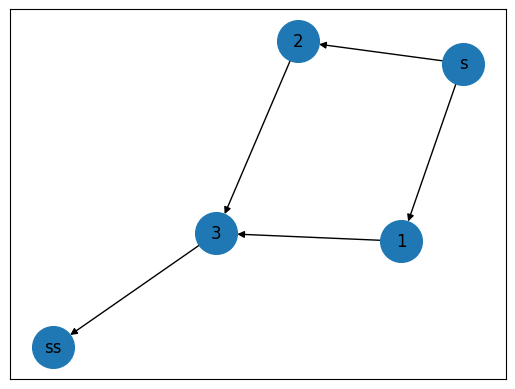

In [7]:
drawGraph(GxNodes, GxEdges)

Then we set needed parameters for genetic algorithm and make Idividual with its hromosome represented as steps

In [8]:
TOURNAMENT_SIZE = 10
POPULATION_SIZE = 100
MUTATION_RATE = 0.3
NUM_GENERATIONS = 100
ELITISIM_SIZE = 40
BUDGET = 40

In [9]:
import random
import numpy as np

class Individual:
    
    def __init__(self, graph, costs, budget):
        self.budget = budget
        self.graph = graph
        self.costs = costs
        self.steps = self.initSteps()
        print(self.steps)
        self.fitness = self.calcFitness()
    
    def isFeasible(self, steps):
        return self.budgetValue(steps) < self.budget
        
    def initSteps(self):
        solution = [0 for _ in range(len(costs))]

        for node in self.costs:
            if node == 's' or node == 'ss':
                continue
            solution[int(node)] = random.randrange(len(costs[node]))
        if not self.isFeasible(solution):
            self.correctNonFeasible(solution)
        return solution
    def budgetValue(self, steps):
        cost = 0
        for index in range(1, len(steps)-1):
            cost += self.costs[str(index)][steps[index]][1]
        return cost
        
    def __lt__(self,other):
#         print(self.fitness, other.fitness, self.fitness < other.fitness)
        return self.fitness < other.fitness
    
    def calcFitness(self):
        return 1 / self.solutionValue(self.graph['s'], 0)
    
    def solutionValue(self, nodes, earliestStartTime):
        if nodes == []:
            return earliestStartTime
        durations = set()
        newNodes = set()
    #     print(nodes)
        for node in nodes:
    #         print(node)
            if node == 'ss':
                durations.add(0)
                continue
            step = self.steps[int(node)]
            durations.add(costs[node][step][0])
            for ancestor in self.graph[node]:
                newNodes.add(ancestor)
        earliestStartTime += max(durations)
        return self.solutionValue(list(newNodes), earliestStartTime)
    import numpy as np

    def correctNonFeasible(self, solution):
        costs = self.costs
        budget = self.budget
        solutionValue = self.budgetValue(solution)
        if solutionValue < budget:
            return

        difference = budget - solutionValue
        solutionCosts = []

        solutionCosts.append(0)
        for i in range(1, len(solution)-1):
            solutionCosts.append(costs[str(i)][solution[i]][1])
        solutionCosts.append(0)

        for i in range(1, len(solution)-1):
            argMax = np.argmax(solutionCosts)
            for j in range(len(costs[str(argMax)])):
                if costs[str(argMax)][j][1] < costs[str(argMax)][solution[argMax]][1]:
                    solution[argMax] = j
                    if self.budgetValue(solution) < budget:
                        return solution
            solutionCosts[argMax] = 0
        else:
            print("Ne moze se popraviti")

In [10]:
def selection(population):
    bestFitness = float('-inf')
    index = -1
    for i in range(TOURNAMENT_SIZE):
        randomIndividual = random.randrange(len(population))
        if population[randomIndividual].fitness < bestFitness:
            bestFitness = population[randomIndividual].fitness
            index = randomIndividual
    return index 

In [11]:
def crossover(parent1, parent2, child1, child2):
    breakpoint = random.randrange(len(parent1.steps))
    
    child1.steps[:breakpoint] = parent1.steps[:breakpoint]
    child2.steps[:breakpoint] = parent2.steps[:breakpoint]
    
    child1.steps[breakpoint:] = parent2.steps[breakpoint:]
    child2.steps[breakpoint:] = parent1.steps[breakpoint:]
    
    child1.correctNonFeasible(child1.steps)
    child2.correctNonFeasible(child2.steps)

In [12]:
def mutation(individual, costs):
    MUTATION_PROB = 0.05
    for i in range(1, len(individual.steps)-1):
        if random.random() < MUTATION_RATE:
            step = random.randrange(len(costs[str(i)]))
            individual.steps[i] = step
    individual.correctNonFeasible(individual.steps)

In [13]:
population = [Individual(nodes, costs, BUDGET) for _ in range(POPULATION_SIZE)]
newPopulation = [Individual(nodes, costs, BUDGET) for _ in range(POPULATION_SIZE)]

for i in range(NUM_GENERATIONS):
    population = sorted(population, reverse=True)
    newPopulation[:ELITISIM_SIZE] = population[:ELITISIM_SIZE]
    for j in range(ELITISIM_SIZE, POPULATION_SIZE, 2):
        parent1Index = selection(population)
        parent2Index = selection(population)
        
        crossover(population[parent1Index], population[parent2Index], newPopulation[j], newPopulation[j+1])
        
        mutation(newPopulation[j], costs)
        mutation(newPopulation[j+1], costs)
        
        newPopulation[j].fitness = newPopulation[j].calcFitness()
        newPopulation[j+1].fitness = newPopulation[j+1].calcFitness()
        
    population = newPopulation


bestIndividual = max(population)
print(f'solution: {bestIndividual.steps}, fitness: {bestIndividual.fitness}, cost: {1 / bestIndividual.fitness}, budget:{bestIndividual.budgetValue(bestIndividual.steps)}')

Ne moze se popraviti
[0, 1, 0, 2, 0]
Ne moze se popraviti
[0, 1, 0, 2, 0]
Ne moze se popraviti
[0, 1, 0, 2, 0]
Ne moze se popraviti
[0, 1, 0, 2, 0]
Ne moze se popraviti
[0, 1, 0, 2, 0]
Ne moze se popraviti
[0, 1, 0, 2, 0]
Ne moze se popraviti
[0, 1, 0, 2, 0]
Ne moze se popraviti
[0, 1, 0, 2, 0]
Ne moze se popraviti
[0, 1, 0, 2, 0]
Ne moze se popraviti
[0, 1, 0, 2, 0]
Ne moze se popraviti
[0, 1, 0, 2, 0]
Ne moze se popraviti
[0, 1, 0, 2, 0]
Ne moze se popraviti
[0, 1, 0, 2, 0]
Ne moze se popraviti
[0, 1, 0, 2, 0]
Ne moze se popraviti
[0, 1, 0, 2, 0]
Ne moze se popraviti
[0, 1, 0, 2, 0]
Ne moze se popraviti
[0, 1, 0, 2, 0]
Ne moze se popraviti
[0, 1, 0, 2, 0]
Ne moze se popraviti
[0, 1, 0, 2, 0]
Ne moze se popraviti
[0, 1, 0, 2, 0]
Ne moze se popraviti
[0, 1, 0, 2, 0]
Ne moze se popraviti
[0, 1, 0, 2, 0]
Ne moze se popraviti
[0, 1, 0, 2, 0]
Ne moze se popraviti
[0, 1, 0, 2, 0]
Ne moze se popraviti
[0, 1, 0, 2, 0]
Ne moze se popraviti
[0, 1, 0, 2, 0]
Ne moze se popraviti
[0, 1, 0, 2, 0]
N

Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se popraviti
Ne moze se po